<center>
    <h1> Machine Learning for Computer Vision</h1>
    <h2> Project Work (2/2) </h2>
    <a href="mailto:matteo.donati10@studio.unibo.it">Matteo Donati</a> (ID: 0001032227)
</center>

<br>

## Libraries

In [1]:
!pip install -U "git+https://github.com/facebookresearch/fvcore"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore to /tmp/pip-req-build-tfynlf9a
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore /tmp/pip-req-build-tfynlf9a
  Resolved https://github.com/facebookresearch/fvcore to commit 3120dd1af6a60528460e61eab42c94926c6ebbe5
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65424 sha256=1a43bfdaace91b8cc3fa8055a5d6a7dc9ad58a6b0f978c5dc3fdcecd79ce6d74
  Stored in directory: /tmp/pip-ephem-wheel-cache-laagn9i4/wheels/51/52/07/e1a7fde1786c36d1e4ca408afe8979cfffa255c078f3725d45
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=b7e0a534cfdee70a25b2e163a46e82ce8a2a1f2ee3da099289c72c4821ba7e

In [2]:
!git clone https://github.com/akamaster/pytorch_resnet_cifar10 && mv pytorch_resnet_cifar10/resnet.py .

# Read the resnet.py file
with open("resnet.py", "r") as file :
  f = file.read()

# Replace "out = F.avg_pool2d(out, out.size()[3])" with "out = F.avg_pool2d(out, int(out.size()[3]))".
f = f.replace("out = F.avg_pool2d(out, out.size()[3])", "out = F.avg_pool2d(out, int(out.size()[3]))")

# Write the resnet.py file.
with open("resnet.py", "w") as file:
  file.write(f)

Cloning into 'pytorch_resnet_cifar10'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), 84.32 MiB | 11.32 MiB/s, done.
Updating files: 100% (12/12), done.


In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
from torchvision import transforms as T
from CMT import ReducedStem, PatchEmbedding, LPU, MHSA, LMHSA, IRFFN, CMTBlock, ReducedCMT
from utilities import get_cifar10, create_data_loaders, get_flops, get_training_objects, train, test, read_output_files, plot_validation, plot_accuracy_vs_flops
from resnet import ResNet, BasicBlock
import multiprocessing as mp
from matplotlib import pyplot as plt
import pickle
from sklearn.metrics import classification_report

In [4]:
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

set_reproducibility(0)

## Data Loading and Preprocessing

In [ ]:
# Training transformations.
train_transform = T.Compose([
    T.RandomCrop(32, padding = 4),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.Resize(32),
    T.ToTensor()
])

# Test transformations.
test_transform = T.Compose([
    T.Resize(32),
    T.ToTensor()
])

# Creating data loaders.
train_loader, val_loader, test_loader = create_data_loaders(
    train_transform,
    test_transform,
    img_size = 32,
    batch_size = 32,
    num_workers = mp.cpu_count()
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


## Models Definition and Training

In [ ]:
# Choosing between GPU and CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(ReducedStem.__doc__)


  The stem block of the reduced CMT architecture:
	
   - 3 × 3, 16 convolution.
	 
  The single layer is followed by a batch norm layer and GELU activation.
	


In [ ]:
print(PatchEmbedding.__doc__)


  The patch embedding block of the CMT architecture:
	
   - 2 × 2, stride 2 convolution.
	 
  The single layer is followed by layer norm.
	


In [ ]:
print(LPU.__doc__)


  The patch embedding block of the CMT architecture:
	
   - 3 × 3, depthwise convolution.
	 
  The LPU also adds a residual connection to compute LPU(X) = DWConv(X) + X.
	


In [ ]:
print(MHSA.__doc__)


  The standard multi-head self-attention module.
  


In [ ]:
print(LMHSA.__doc__)


  The lightweight multi-head self-attention module.
  


In [ ]:
print(IRFFN.__doc__)


  The IRFFN block of the CMT architecture:
	
   - 1 × 1, Cout = Cin * R convolution.
   - 3 × 3, Cout = Cin depthwise convolution.
   - 1 × 1, Cout = Cin / R convolution.
	 
  The input of the IRFFN is layer normalized, and each layer is followed 
  by a batch norm layer and GELU activation. Moreover, The IRFFN module 
  also adds a residual connection to compute IRFFN(X) = Conv(F(Conv(X))),
  F(X) = DWConv(X) + X.
  


In [ ]:
print(CMTBlock.__doc__)


  The CMT block of the CMT architecture:
	
   - LPU block.
   - Eventual (L)MHSA block.
   - IRFFN.
  


In [ ]:
print(ReducedCMT.__doc__)


  The reduced CMT architecture:
	
   - The reduced stem block.
   - Three stages composed of the same number of CMT blocks and patch embedding layers.
   - Global average pooling.
   - 1 × 1, 256 convolution.
   - Classification head.
  


### Lightweight MHSA model ($m_1$)

In [ ]:
# Defining the reduced model that uses LMHSA.
m_1 = ReducedCMT(
  in_channels = 3,
  stem_channels = 16,
  channels = [46, 92, 184],
  block_layers = [2, 2, 2],
  k = [4, 2, 1],
  heads = [1, 2, 4],
  R = 3.6,
  input_size = 32,
  classes = 10,
  attention_type = "light")

# Printing number of parameters.
print(f"m_1 has {sum(p.numel() for p in m_1.parameters())} parameters.")

m_1 has 1196448 parameters.


In [ ]:
# Computing and printing number of FLOPs.
get_flops(m_1, (1, 3, 32, 32))

ReducedCMT(
  #params: 1.2M, #flops: 41.41M
  (stem): ReducedStem(
    #params: 0.48K, #flops: 0.52M
    (conv): Conv2d(
      3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      #params: 0.45K, #flops: 0.44M
    )
    (bn): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 81.92K
    )
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    #params: 2.99K, #flops: 0.8M
    (conv): Conv2d(
      16, 46, kernel_size=(2, 2), stride=(2, 2)
      #params: 2.99K, #flops: 0.75M
    )
  )
  (pe2): PatchEmbedding(
    #params: 17.02K, #flops: 1.11M
    (conv): Conv2d(
      46, 92, kernel_size=(2, 2), stride=(2, 2)
      #params: 17.02K, #flops: 1.08M
    )
  )
  (pe3): PatchEmbedding(
    #params: 67.9K, #flops: 1.1M
    (conv): Conv2d(
      92, 184, kernel_size=(2, 2), stride=(2, 2)
      #params: 67.9K, #flops: 1.08M
    )
  )
  (stage1): Sequential(
    #params: 63.56K, #flops: 13M
    (0): CMTBlock(
 

In [ ]:
# Loading model to device.
m_1.to(device)

ReducedCMT(
  (stem): ReducedStem(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    (conv): Conv2d(16, 46, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe2): PatchEmbedding(
    (conv): Conv2d(46, 92, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe3): PatchEmbedding(
    (conv): Conv2d(92, 184, kernel_size=(2, 2), stride=(2, 2))
  )
  (stage1): Sequential(
    (0): CMTBlock(
      (lpu): LPU(
        (dwconv): Conv2d(46, 46, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=46)
      )
      (mhsa): LMHSA(
        (dwconv): Conv2d(46, 46, kernel_size=(4, 4), stride=(4, 4), groups=46)
        (fc_q): Linear(in_features=46, out_features=46, bias=True)
        (fc_k): Linear(in_features=46, out_features=46, bias=True)
        (fc_v): Linear(in_features=46, out_features=46, bias=True)
        (fc_o): Li

In [ ]:
# Defining training recipe.
EPOCHS, loss_fn, optimizer, scheduler = get_training_objects(m_1)

In [ ]:
# Training.
history = train(m_1, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "model": m_1.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint1_32x32.pt")

# Saving history.
with open("m_1_history_32x32.pkl", "wb") as f:
  pickle.dump(history, f)

Epoch  1/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 46.81it/s]


train_loss: 1.6344, train_accuracy: 0.3999, val_loss: 1.3950, val_accuracy: 0.4886, lr: 6.0000e-05

Epoch  2/25:


Validation: 100%|██████████| 313/313 [00:07<00:00, 39.18it/s]


train_loss: 1.3294, train_accuracy: 0.5185, val_loss: 1.2430, val_accuracy: 0.5536, lr: 5.9763e-05

Epoch  3/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 47.56it/s]


train_loss: 1.2041, train_accuracy: 0.5695, val_loss: 1.1382, val_accuracy: 0.5961, lr: 5.9057e-05

Epoch  4/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.46it/s]


train_loss: 1.1077, train_accuracy: 0.6041, val_loss: 1.0612, val_accuracy: 0.6212, lr: 5.7893e-05

Epoch  5/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 47.28it/s]


train_loss: 1.0361, train_accuracy: 0.6316, val_loss: 1.0164, val_accuracy: 0.6438, lr: 5.6289e-05

Epoch  6/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 47.64it/s]


train_loss: 0.9781, train_accuracy: 0.6531, val_loss: 0.9585, val_accuracy: 0.6634, lr: 5.4271e-05

Epoch  7/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.20it/s]


train_loss: 0.9354, train_accuracy: 0.6687, val_loss: 0.9194, val_accuracy: 0.6723, lr: 5.1869e-05

Epoch  8/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 47.79it/s]


train_loss: 0.8953, train_accuracy: 0.6822, val_loss: 0.8934, val_accuracy: 0.6897, lr: 4.9123e-05

Epoch  9/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 47.32it/s]


train_loss: 0.8569, train_accuracy: 0.6956, val_loss: 0.8687, val_accuracy: 0.6966, lr: 4.6075e-05

Epoch 10/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 47.08it/s]


train_loss: 0.8240, train_accuracy: 0.7071, val_loss: 0.8515, val_accuracy: 0.7028, lr: 4.2773e-05

Epoch 11/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.31it/s]


train_loss: 0.8020, train_accuracy: 0.7170, val_loss: 0.8319, val_accuracy: 0.7079, lr: 3.9271e-05

Epoch 12/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 47.41it/s]


train_loss: 0.7780, train_accuracy: 0.7264, val_loss: 0.8083, val_accuracy: 0.7197, lr: 3.5621e-05

Epoch 13/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.13it/s]


train_loss: 0.7542, train_accuracy: 0.7338, val_loss: 0.7942, val_accuracy: 0.7243, lr: 3.1884e-05

Epoch 14/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 47.65it/s]


train_loss: 0.7345, train_accuracy: 0.7415, val_loss: 0.7820, val_accuracy: 0.7236, lr: 2.8116e-05

Epoch 15/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 47.09it/s]


train_loss: 0.7169, train_accuracy: 0.7485, val_loss: 0.7710, val_accuracy: 0.7323, lr: 2.4379e-05

Epoch 16/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 49.03it/s]


train_loss: 0.6976, train_accuracy: 0.7550, val_loss: 0.7630, val_accuracy: 0.7324, lr: 2.0729e-05

Epoch 17/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.22it/s]


train_loss: 0.6875, train_accuracy: 0.7610, val_loss: 0.7418, val_accuracy: 0.7408, lr: 1.7227e-05

Epoch 18/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.76it/s]


train_loss: 0.6729, train_accuracy: 0.7631, val_loss: 0.7447, val_accuracy: 0.7427, lr: 1.3925e-05

Epoch 19/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.61it/s]


train_loss: 0.6669, train_accuracy: 0.7663, val_loss: 0.7418, val_accuracy: 0.7404, lr: 1.0877e-05

Epoch 20/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.62it/s]


train_loss: 0.6531, train_accuracy: 0.7682, val_loss: 0.7278, val_accuracy: 0.7466, lr: 8.1309e-06

Epoch 21/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 49.34it/s]


train_loss: 0.6485, train_accuracy: 0.7722, val_loss: 0.7308, val_accuracy: 0.7476, lr: 5.7295e-06

Epoch 22/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 49.65it/s]


train_loss: 0.6429, train_accuracy: 0.7761, val_loss: 0.7207, val_accuracy: 0.7483, lr: 3.7108e-06

Epoch 23/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.20it/s]


train_loss: 0.6424, train_accuracy: 0.7732, val_loss: 0.7213, val_accuracy: 0.7461, lr: 2.1067e-06

Epoch 24/25:


Validation: 100%|██████████| 313/313 [00:07<00:00, 42.76it/s]


train_loss: 0.6363, train_accuracy: 0.7762, val_loss: 0.7238, val_accuracy: 0.7482, lr: 9.4251e-07

Epoch 25/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.65it/s]



train_loss: 0.6407, train_accuracy: 0.7741, val_loss: 0.7230, val_accuracy: 0.7475, lr: 2.3656e-07


### Standard MHSA model ($m_2$)

In [ ]:
# Defining the reduced model that uses MHSA.
m_2 = ReducedCMT(
  in_channels = 3,
  stem_channels = 16,
  channels = [46, 92, 184],
  block_layers = [2, 2, 2],
  k = [4, 2, 1],
  heads = [1, 2, 4],
  R = 3.6,
  input_size = 32,
  classes = 10,
  attention_type = "standard")

# Printing number of parameters.
print(f"m_2 has {sum(p.numel() for p in m_2.parameters())} parameters.")

m_2 has 1178892 parameters.


In [ ]:
# Computing and printing number of FLOPs.
get_flops(m_2, (1, 3, 32, 32))

ReducedCMT(
  #params: 1.18M, #flops: 57.42M
  (stem): ReducedStem(
    #params: 0.48K, #flops: 0.52M
    (conv): Conv2d(
      3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      #params: 0.45K, #flops: 0.44M
    )
    (bn): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 81.92K
    )
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    #params: 2.99K, #flops: 0.8M
    (conv): Conv2d(
      16, 46, kernel_size=(2, 2), stride=(2, 2)
      #params: 2.99K, #flops: 0.75M
    )
  )
  (pe2): PatchEmbedding(
    #params: 17.02K, #flops: 1.11M
    (conv): Conv2d(
      46, 92, kernel_size=(2, 2), stride=(2, 2)
      #params: 17.02K, #flops: 1.08M
    )
  )
  (pe3): PatchEmbedding(
    #params: 67.9K, #flops: 1.1M
    (conv): Conv2d(
      92, 184, kernel_size=(2, 2), stride=(2, 2)
      #params: 67.9K, #flops: 1.08M
    )
  )
  (stage1): Sequential(
    #params: 53.8K, #flops: 26.29M
    (0): CMTBlock

In [ ]:
# Loading model to device.
m_2.to(device)

ReducedCMT(
  (stem): ReducedStem(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    (conv): Conv2d(16, 46, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe2): PatchEmbedding(
    (conv): Conv2d(46, 92, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe3): PatchEmbedding(
    (conv): Conv2d(92, 184, kernel_size=(2, 2), stride=(2, 2))
  )
  (stage1): Sequential(
    (0): CMTBlock(
      (lpu): LPU(
        (dwconv): Conv2d(46, 46, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=46)
      )
      (mhsa): MHSA(
        (fc_q): Linear(in_features=46, out_features=46, bias=True)
        (fc_k): Linear(in_features=46, out_features=46, bias=True)
        (fc_v): Linear(in_features=46, out_features=46, bias=True)
        (fc_o): Linear(in_features=46, out_features=46, bias=True)
      )
      (irffn): IRFFN(
 

In [ ]:
# Defining training recipe.
EPOCHS, loss_fn, optimizer, scheduler = get_training_objects(m_2)

In [ ]:
# Training.
history = train(m_2, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "model": m_2.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint2_32x32.pt")

# Saving history.
with open("m_2_history_32x32.pkl", "wb") as f:
  pickle.dump(history, f)

Epoch  1/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.75it/s]


train_loss: 1.6567, train_accuracy: 0.3852, val_loss: 1.4215, val_accuracy: 0.4754, lr: 6.0000e-05

Epoch  2/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 52.03it/s]


train_loss: 1.3433, train_accuracy: 0.5134, val_loss: 1.2642, val_accuracy: 0.5388, lr: 5.9763e-05

Epoch  3/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.33it/s]


train_loss: 1.2155, train_accuracy: 0.5630, val_loss: 1.1543, val_accuracy: 0.5856, lr: 5.9057e-05

Epoch  4/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 50.52it/s]


train_loss: 1.1255, train_accuracy: 0.5974, val_loss: 1.0799, val_accuracy: 0.6180, lr: 5.7893e-05

Epoch  5/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 50.80it/s]


train_loss: 1.0511, train_accuracy: 0.6278, val_loss: 1.0187, val_accuracy: 0.6397, lr: 5.6289e-05

Epoch  6/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.80it/s]


train_loss: 0.9964, train_accuracy: 0.6455, val_loss: 0.9902, val_accuracy: 0.6484, lr: 5.4271e-05

Epoch  7/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.21it/s]


train_loss: 0.9507, train_accuracy: 0.6641, val_loss: 0.9265, val_accuracy: 0.6698, lr: 5.1869e-05

Epoch  8/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.30it/s]


train_loss: 0.9040, train_accuracy: 0.6797, val_loss: 0.9006, val_accuracy: 0.6829, lr: 4.9123e-05

Epoch  9/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 50.83it/s]


train_loss: 0.8690, train_accuracy: 0.6906, val_loss: 0.8774, val_accuracy: 0.6932, lr: 4.6075e-05

Epoch 10/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 50.45it/s]


train_loss: 0.8339, train_accuracy: 0.7054, val_loss: 0.8546, val_accuracy: 0.7023, lr: 4.2773e-05

Epoch 11/25:


Validation: 100%|██████████| 313/313 [00:05<00:00, 52.26it/s]


train_loss: 0.8085, train_accuracy: 0.7137, val_loss: 0.8375, val_accuracy: 0.7065, lr: 3.9271e-05

Epoch 12/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 52.10it/s]


train_loss: 0.7804, train_accuracy: 0.7234, val_loss: 0.8171, val_accuracy: 0.7161, lr: 3.5621e-05

Epoch 13/25:


Validation: 100%|██████████| 313/313 [00:05<00:00, 52.19it/s]


train_loss: 0.7541, train_accuracy: 0.7348, val_loss: 0.8074, val_accuracy: 0.7142, lr: 3.1884e-05

Epoch 14/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.80it/s]


train_loss: 0.7369, train_accuracy: 0.7395, val_loss: 0.7807, val_accuracy: 0.7285, lr: 2.8116e-05

Epoch 15/25:


Validation: 100%|██████████| 313/313 [00:05<00:00, 52.57it/s]


train_loss: 0.7163, train_accuracy: 0.7466, val_loss: 0.7700, val_accuracy: 0.7339, lr: 2.4379e-05

Epoch 16/25:


Validation: 100%|██████████| 313/313 [00:05<00:00, 52.70it/s]


train_loss: 0.6991, train_accuracy: 0.7529, val_loss: 0.7654, val_accuracy: 0.7322, lr: 2.0729e-05

Epoch 17/25:


Validation: 100%|██████████| 313/313 [00:05<00:00, 52.17it/s]


train_loss: 0.6888, train_accuracy: 0.7566, val_loss: 0.7455, val_accuracy: 0.7388, lr: 1.7227e-05

Epoch 18/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.74it/s]


train_loss: 0.6731, train_accuracy: 0.7645, val_loss: 0.7462, val_accuracy: 0.7389, lr: 1.3925e-05

Epoch 19/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 52.15it/s]


train_loss: 0.6659, train_accuracy: 0.7633, val_loss: 0.7376, val_accuracy: 0.7398, lr: 1.0877e-05

Epoch 20/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 50.74it/s]


train_loss: 0.6523, train_accuracy: 0.7699, val_loss: 0.7346, val_accuracy: 0.7454, lr: 8.1309e-06

Epoch 21/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.91it/s]


train_loss: 0.6486, train_accuracy: 0.7707, val_loss: 0.7317, val_accuracy: 0.7447, lr: 5.7295e-06

Epoch 22/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.55it/s]


train_loss: 0.6432, train_accuracy: 0.7741, val_loss: 0.7263, val_accuracy: 0.7472, lr: 3.7108e-06

Epoch 23/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.16it/s]


train_loss: 0.6388, train_accuracy: 0.7751, val_loss: 0.7236, val_accuracy: 0.7491, lr: 2.1067e-06

Epoch 24/25:


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.69it/s]


train_loss: 0.6404, train_accuracy: 0.7756, val_loss: 0.7167, val_accuracy: 0.7490, lr: 9.4251e-07

Epoch 25/25:


Validation: 100%|██████████| 313/313 [00:05<00:00, 52.24it/s]


train_loss: 0.6382, train_accuracy: 0.7745, val_loss: 0.7105, val_accuracy: 0.7521, lr: 2.3656e-07


### No attention model ($m_3$)

In [ ]:
# Defining the reduced model that uses no attention.
m_3 = ReducedCMT(
  in_channels = 3,
  stem_channels = 16,
  channels = [46, 92, 184],
  block_layers = [2, 2, 2],
  k = [4, 2, 1],
  heads = [1, 2, 4],
  R = 3.6,
  input_size = 32,
  classes = 10,
  attention_type = None)

# Printing number of parameters.
print(f"m_3 has {sum(p.numel() for p in m_3.parameters())} parameters.")

m_3 has 820828 parameters.


In [ ]:
# Computing and printing number of FLOPs.
get_flops(m_3, (1, 3, 32, 32))

ReducedCMT(
  #params: 0.82M, #flops: 30.5M
  (stem): ReducedStem(
    #params: 0.48K, #flops: 0.52M
    (conv): Conv2d(
      3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      #params: 0.45K, #flops: 0.44M
    )
    (bn): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      #params: 32, #flops: 81.92K
    )
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    #params: 2.99K, #flops: 0.8M
    (conv): Conv2d(
      16, 46, kernel_size=(2, 2), stride=(2, 2)
      #params: 2.99K, #flops: 0.75M
    )
  )
  (pe2): PatchEmbedding(
    #params: 17.02K, #flops: 1.11M
    (conv): Conv2d(
      46, 92, kernel_size=(2, 2), stride=(2, 2)
      #params: 17.02K, #flops: 1.08M
    )
  )
  (pe3): PatchEmbedding(
    #params: 67.9K, #flops: 1.1M
    (conv): Conv2d(
      92, 184, kernel_size=(2, 2), stride=(2, 2)
      #params: 67.9K, #flops: 1.08M
    )
  )
  (stage1): Sequential(
    #params: 36.51K, #flops: 9.8M
    (0): CMTBlock(


In [ ]:
# Loading model to device.
m_3.to(device)

ReducedCMT(
  (stem): ReducedStem(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gelu): GELU(approximate='none')
  )
  (pe1): PatchEmbedding(
    (conv): Conv2d(16, 46, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe2): PatchEmbedding(
    (conv): Conv2d(46, 92, kernel_size=(2, 2), stride=(2, 2))
  )
  (pe3): PatchEmbedding(
    (conv): Conv2d(92, 184, kernel_size=(2, 2), stride=(2, 2))
  )
  (stage1): Sequential(
    (0): CMTBlock(
      (lpu): LPU(
        (dwconv): Conv2d(46, 46, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=46)
      )
      (irffn): IRFFN(
        (conv1): Conv2d(46, 165, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(165, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dwconv): Conv2d(165, 165, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=165)
        (bn2): BatchNorm2d(165, eps

In [ ]:
# Defining training recipe.
EPOCHS, loss_fn, optimizer, scheduler = get_training_objects(m_3)

In [ ]:
# Training.
history = train(m_3, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "model": m_3.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint3_32x32.pt")

# Saving history.
with open("m_3_history_32x32.pkl", "wb") as f:
  pickle.dump(history, f)

Epoch  1/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.52it/s]


train_loss: 1.6562, train_accuracy: 0.3898, val_loss: 1.3978, val_accuracy: 0.4931, lr: 6.0000e-05

Epoch  2/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.19it/s]


train_loss: 1.3306, train_accuracy: 0.5168, val_loss: 1.2244, val_accuracy: 0.5557, lr: 5.9763e-05

Epoch  3/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.97it/s]


train_loss: 1.1951, train_accuracy: 0.5719, val_loss: 1.1369, val_accuracy: 0.5894, lr: 5.9057e-05

Epoch  4/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.46it/s]


train_loss: 1.0930, train_accuracy: 0.6093, val_loss: 1.0552, val_accuracy: 0.6273, lr: 5.7893e-05

Epoch  5/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 64.51it/s]


train_loss: 1.0270, train_accuracy: 0.6354, val_loss: 1.0007, val_accuracy: 0.6503, lr: 5.6289e-05

Epoch  6/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.52it/s]


train_loss: 0.9733, train_accuracy: 0.6520, val_loss: 0.9569, val_accuracy: 0.6577, lr: 5.4271e-05

Epoch  7/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.49it/s]


train_loss: 0.9309, train_accuracy: 0.6703, val_loss: 0.9280, val_accuracy: 0.6705, lr: 5.1869e-05

Epoch  8/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.38it/s]


train_loss: 0.8891, train_accuracy: 0.6858, val_loss: 0.8763, val_accuracy: 0.6893, lr: 4.9123e-05

Epoch  9/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.31it/s]


train_loss: 0.8600, train_accuracy: 0.6962, val_loss: 0.8568, val_accuracy: 0.6989, lr: 4.6075e-05

Epoch 10/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.59it/s]


train_loss: 0.8203, train_accuracy: 0.7100, val_loss: 0.8342, val_accuracy: 0.7019, lr: 4.2773e-05

Epoch 11/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 64.46it/s]


train_loss: 0.7844, train_accuracy: 0.7240, val_loss: 0.8093, val_accuracy: 0.7167, lr: 3.9271e-05

Epoch 12/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.72it/s]


train_loss: 0.7644, train_accuracy: 0.7304, val_loss: 0.7921, val_accuracy: 0.7236, lr: 3.5621e-05

Epoch 13/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.27it/s]


train_loss: 0.7443, train_accuracy: 0.7373, val_loss: 0.7757, val_accuracy: 0.7272, lr: 3.1884e-05

Epoch 14/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.46it/s]


train_loss: 0.7219, train_accuracy: 0.7472, val_loss: 0.7628, val_accuracy: 0.7343, lr: 2.8116e-05

Epoch 15/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.74it/s]


train_loss: 0.7062, train_accuracy: 0.7513, val_loss: 0.7513, val_accuracy: 0.7368, lr: 2.4379e-05

Epoch 16/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 67.55it/s]


train_loss: 0.6919, train_accuracy: 0.7571, val_loss: 0.7415, val_accuracy: 0.7410, lr: 2.0729e-05

Epoch 17/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.66it/s]


train_loss: 0.6715, train_accuracy: 0.7654, val_loss: 0.7325, val_accuracy: 0.7472, lr: 1.7227e-05

Epoch 18/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.14it/s]


train_loss: 0.6582, train_accuracy: 0.7672, val_loss: 0.7167, val_accuracy: 0.7470, lr: 1.3925e-05

Epoch 19/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.21it/s]


train_loss: 0.6511, train_accuracy: 0.7716, val_loss: 0.7246, val_accuracy: 0.7486, lr: 1.0877e-05

Epoch 20/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.33it/s]


train_loss: 0.6493, train_accuracy: 0.7736, val_loss: 0.7162, val_accuracy: 0.7564, lr: 8.1309e-06

Epoch 21/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.12it/s]


train_loss: 0.6425, train_accuracy: 0.7752, val_loss: 0.7065, val_accuracy: 0.7498, lr: 5.7295e-06

Epoch 22/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 65.30it/s]


train_loss: 0.6317, train_accuracy: 0.7794, val_loss: 0.7079, val_accuracy: 0.7522, lr: 3.7108e-06

Epoch 23/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.02it/s]


train_loss: 0.6298, train_accuracy: 0.7779, val_loss: 0.7077, val_accuracy: 0.7506, lr: 2.1067e-06

Epoch 24/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.42it/s]


train_loss: 0.6307, train_accuracy: 0.7796, val_loss: 0.6982, val_accuracy: 0.7534, lr: 9.4251e-07

Epoch 25/25:


Validation: 100%|██████████| 313/313 [00:04<00:00, 66.80it/s]



train_loss: 0.6239, train_accuracy: 0.7819, val_loss: 0.7025, val_accuracy: 0.7512, lr: 2.3656e-07


### ResNet-110 ($m_4$)

In [ ]:
# Defining the ResNet-758 model ((n = 18) * 6 + 2 = 110 trainable layers). 
m_4 = ResNet(BasicBlock, [18, 18, 18])

# Printing number of parameters.
print(f"m_4 has {sum(p.numel() for p in m_4.parameters())} parameters.")

m_4 has 1727962 parameters.


In [ ]:
# Computing and printing number of FLOPs.
get_flops(m_4, (1, 3, 32, 32))

N/A indicates a possibly missing statistic due to how the module was called. Missing values are still included in the parent's total.
ResNet(
  #params: 1.73M, #flops: 0.26G
  (conv1): Conv2d(
    3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    #params: 0.43K, #flops: 0.44M
  )
  (bn1): BatchNorm2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    #params: 32, #flops: 81.92K
  )
  (layer1): Sequential(
    #params: 84.1K, #flops: 87.88M
    (0): BasicBlock(
      #params: 4.67K, #flops: 4.88M
      (conv1): Conv2d(
        16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        #params: 2.3K, #flops: 2.36M
      )
      (bn1): BatchNorm2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        #params: 32, #flops: 81.92K
      )
      (conv2): Conv2d(
        16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        #params: 2.3K, #flops: 2.36M
      )
      (bn2): B

In [ ]:
# Loading model to device.
m_4.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [ ]:
# Defining training recipe.
EPOCHS, loss_fn, optimizer, scheduler = get_training_objects(m_4)

In [ ]:
# Training.
history = train(m_4, optimizer, scheduler, loss_fn, train_loader, val_loader, EPOCHS, device)

# Creating a checkpoint.
checkpoint = {
  "model": m_4.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict()
}

# Saving the model.
torch.save(checkpoint, "checkpoint4_32x32.pt")

# Saving history.
with open("m_4_history_32x32.pkl", "wb") as f:
  pickle.dump(history, f)

Epoch  1/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.72it/s]


train_loss: 2.1759, train_accuracy: 0.2693, val_loss: 1.8090, val_accuracy: 0.3323, lr: 6.0000e-05

Epoch  2/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.61it/s]


train_loss: 1.6783, train_accuracy: 0.3805, val_loss: 1.6240, val_accuracy: 0.4065, lr: 5.9763e-05

Epoch  3/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.05it/s]


train_loss: 1.5419, train_accuracy: 0.4310, val_loss: 1.4834, val_accuracy: 0.4515, lr: 5.9057e-05

Epoch  4/25:


Validation: 100%|██████████| 313/313 [00:08<00:00, 34.79it/s]


train_loss: 1.4464, train_accuracy: 0.4739, val_loss: 1.3897, val_accuracy: 0.4941, lr: 5.7893e-05

Epoch  5/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.01it/s]


train_loss: 1.3771, train_accuracy: 0.5032, val_loss: 1.3371, val_accuracy: 0.5133, lr: 5.6289e-05

Epoch  6/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.27it/s]


train_loss: 1.3113, train_accuracy: 0.5243, val_loss: 1.2989, val_accuracy: 0.5333, lr: 5.4271e-05

Epoch  7/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.54it/s]


train_loss: 1.2487, train_accuracy: 0.5507, val_loss: 1.2447, val_accuracy: 0.5504, lr: 5.1869e-05

Epoch  8/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.29it/s]


train_loss: 1.1975, train_accuracy: 0.5684, val_loss: 1.1950, val_accuracy: 0.5752, lr: 4.9123e-05

Epoch  9/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.49it/s]


train_loss: 1.1554, train_accuracy: 0.5884, val_loss: 1.1580, val_accuracy: 0.5901, lr: 4.6075e-05

Epoch 10/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.46it/s]


train_loss: 1.1156, train_accuracy: 0.6029, val_loss: 1.0997, val_accuracy: 0.6092, lr: 4.2773e-05

Epoch 11/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.50it/s]


train_loss: 1.0735, train_accuracy: 0.6188, val_loss: 1.1047, val_accuracy: 0.6097, lr: 3.9271e-05

Epoch 12/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 33.65it/s]


train_loss: 1.0418, train_accuracy: 0.6309, val_loss: 1.0533, val_accuracy: 0.6271, lr: 3.5621e-05

Epoch 13/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.16it/s]


train_loss: 1.0031, train_accuracy: 0.6434, val_loss: 1.0336, val_accuracy: 0.6360, lr: 3.1884e-05

Epoch 14/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.57it/s]


train_loss: 0.9825, train_accuracy: 0.6510, val_loss: 1.0089, val_accuracy: 0.6391, lr: 2.8116e-05

Epoch 15/25:


Validation: 100%|██████████| 313/313 [00:08<00:00, 34.85it/s]


train_loss: 0.9596, train_accuracy: 0.6607, val_loss: 0.9825, val_accuracy: 0.6583, lr: 2.4379e-05

Epoch 16/25:


Validation: 100%|██████████| 313/313 [00:08<00:00, 34.78it/s]


train_loss: 0.9406, train_accuracy: 0.6665, val_loss: 0.9782, val_accuracy: 0.6579, lr: 2.0729e-05

Epoch 17/25:


Validation: 100%|██████████| 313/313 [00:08<00:00, 35.09it/s]


train_loss: 0.9185, train_accuracy: 0.6758, val_loss: 0.9602, val_accuracy: 0.6642, lr: 1.7227e-05

Epoch 18/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 32.25it/s]


train_loss: 0.9100, train_accuracy: 0.6776, val_loss: 0.9389, val_accuracy: 0.6732, lr: 1.3925e-05

Epoch 19/25:


Validation: 100%|██████████| 313/313 [00:08<00:00, 35.26it/s]


train_loss: 0.8964, train_accuracy: 0.6853, val_loss: 0.9394, val_accuracy: 0.6692, lr: 1.0877e-05

Epoch 20/25:


Validation: 100%|██████████| 313/313 [00:08<00:00, 34.84it/s]


train_loss: 0.8850, train_accuracy: 0.6871, val_loss: 0.9415, val_accuracy: 0.6724, lr: 8.1309e-06

Epoch 21/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.73it/s]


train_loss: 0.8807, train_accuracy: 0.6886, val_loss: 0.9172, val_accuracy: 0.6775, lr: 5.7295e-06

Epoch 22/25:


Validation: 100%|██████████| 313/313 [00:08<00:00, 35.11it/s]


train_loss: 0.8758, train_accuracy: 0.6909, val_loss: 0.9191, val_accuracy: 0.6789, lr: 3.7108e-06

Epoch 23/25:


Validation: 100%|██████████| 313/313 [00:09<00:00, 34.72it/s]


train_loss: 0.8648, train_accuracy: 0.6929, val_loss: 0.9222, val_accuracy: 0.6805, lr: 2.1067e-06

Epoch 24/25:


Validation: 100%|██████████| 313/313 [00:08<00:00, 34.95it/s]


train_loss: 0.8623, train_accuracy: 0.6957, val_loss: 0.9264, val_accuracy: 0.6737, lr: 9.4251e-07

Epoch 25/25:


Validation: 100%|██████████| 313/313 [00:08<00:00, 35.06it/s]



train_loss: 0.8595, train_accuracy: 0.6964, val_loss: 0.9220, val_accuracy: 0.6798, lr: 2.3656e-07


## Models Testing

### Lightweight MHSA model ($m_1$)

In [ ]:
# Testing the model.
y_pred, y_true = test(m_1, test_loader)

# Computing and saving accuracy.
np.save("m_1_accuracy_32x32.npy", sum(1 for pred, true in zip(y_pred, y_true) if pred == true) / len(y_true))

Testing: 100%|██████████| 313/313 [00:05<00:00, 60.32it/s]


In [ ]:
# Classification report.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1000
           1       0.87      0.86      0.87      1000
           2       0.72      0.67      0.69      1000
           3       0.59      0.59      0.59      1000
           4       0.73      0.76      0.74      1000
           5       0.69      0.64      0.66      1000
           6       0.77      0.86      0.81      1000
           7       0.83      0.80      0.82      1000
           8       0.86      0.88      0.87      1000
           9       0.82      0.86      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



### Standard MHSA model ($m_2$)

In [ ]:
# Testing the model.
y_pred, y_true = test(m_2, test_loader)

# Computing and saving accuracy.
np.save("m_2_accuracy_32x32.npy", sum(1 for pred, true in zip(y_pred, y_true) if pred == true) / len(y_true))

Testing: 100%|██████████| 313/313 [00:04<00:00, 69.45it/s]


In [ ]:
# Classification report.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1000
           1       0.86      0.87      0.87      1000
           2       0.75      0.65      0.70      1000
           3       0.59      0.60      0.59      1000
           4       0.72      0.77      0.74      1000
           5       0.68      0.64      0.66      1000
           6       0.80      0.84      0.82      1000
           7       0.84      0.80      0.82      1000
           8       0.86      0.87      0.86      1000
           9       0.81      0.85      0.83      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



### No attention model ($m_3$) 

In [ ]:
# Testing the model.
y_pred, y_true = test(m_3, test_loader)

# Computing and saving accuracy.
np.save("m_3_accuracy_32x32.npy", sum(1 for pred, true in zip(y_pred, y_true) if pred == true) / len(y_true))

Testing: 100%|██████████| 313/313 [00:03<00:00, 98.52it/s] 


In [ ]:
# Classification report.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1000
           1       0.86      0.88      0.87      1000
           2       0.71      0.69      0.70      1000
           3       0.62      0.55      0.58      1000
           4       0.77      0.75      0.76      1000
           5       0.69      0.67      0.68      1000
           6       0.78      0.84      0.81      1000
           7       0.84      0.82      0.83      1000
           8       0.90      0.87      0.88      1000
           9       0.85      0.86      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



### ResNet-110 ($m_4$)

In [ ]:
# Testing the model.
y_pred, y_true = test(m_4, test_loader, device)

# Computing and saving accuracy.
np.save("m_4_accuracy_32x32.npy", sum(1 for pred, true in zip(y_pred, y_true) if pred == true) / len(y_true))

Testing: 100%|██████████| 313/313 [00:07<00:00, 42.91it/s]


In [ ]:
# Classification report.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1000
           1       0.85      0.83      0.84      1000
           2       0.60      0.58      0.59      1000
           3       0.56      0.47      0.51      1000
           4       0.65      0.65      0.65      1000
           5       0.57      0.64      0.60      1000
           6       0.74      0.80      0.76      1000
           7       0.74      0.74      0.74      1000
           8       0.81      0.84      0.82      1000
           9       0.79      0.79      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.70      0.71      0.70     10000



## Results

In [6]:
# Names.
m_names = ["m_1", "m_2", "m_3", "m_4"]

# FLOPs. These values are taken from the cells above.
flops = {
    "m_1": 41.41e6,
    "m_2": 57.42e6,
    "m_3": 30.5e6,
    "m_4": 0.26e9
}

# Reading output files.
histories, test_acc = read_output_files(m_names, resolution = "32x32")

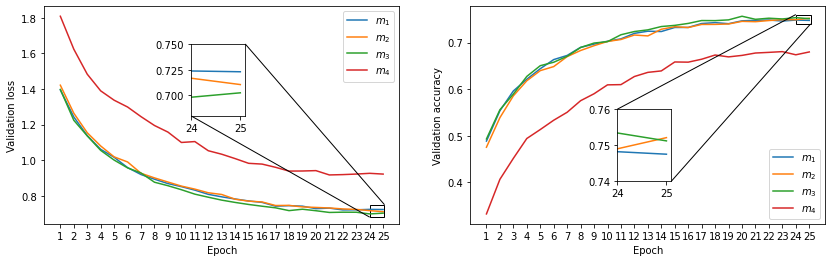

In [13]:
# Plotting validation loss and accuracy.
plot_validation(m_names, histories, [24, 25.1, 0.68, 0.75], [24, 25.1, 0.74, 0.76])

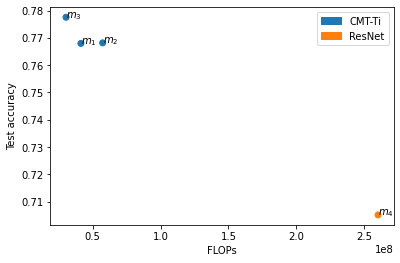

In [7]:
# Plotting test accuracy vs. FLOPs.
plot_accuracy_vs_flops(m_names, flops, test_acc)

## References <a name="references"></a>

1. Jianyuan Guo, Kai Han, Han Wu, Chang Xu, Yehui Tang, Chunjing Xu and Yunhe Wang. CMT: Convolutional Neural Networks Meet Vision Transformers, 2021. [https://arxiv.org/abs/2107.06263](https://arxiv.org/abs/2107.06263).

2. Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. Deep Residual Learning for Image Recognition, 2015. [https://arxiv.org/abs/1512.03385](https://arxiv.org/abs/1512.03385).

3. Yerlan Idelbayev. Proper ResNet Implementation for CIFAR10/CIFAR100 in PyTorch. [https://github.com/akamaster/pytorch_resnet_cifar10](https://github.com/akamaster/pytorch_resnet_cifar10).